In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Historical Data

In [2]:
import pandas as pd
import yfinance as yf
import time
from datetime import datetime
from tqdm import tqdm
import os

# 설정 값
DELAY_BETWEEN_REQUESTS = 1.5  # 각 요청 사이 지연 시간 (초)
RETRY_WAIT_SECONDS = 5        # 실패 시 재시도 전 대기 시간 (초)
MAX_RETRIES = 3               # 최대 재시도 횟수

# 저장 경로
SAVE_DIR = "/content/drive/MyDrive/Data/FNC/Historical_Data"
os.makedirs(SAVE_DIR, exist_ok=True)

# 티커 파일 로딩
df_tickers = pd.read_csv("/content/drive/MyDrive/Data/FNC/Tickers4CL.csv")
tickers = df_tickers["[Symbol]"].dropna().unique()

# 각 티커별로 데이터 수집 및 저장
for ticker in tqdm(tickers, desc="Downloading historical data"):
    success = False
    for attempt in range(MAX_RETRIES):
        try:
            ticker_obj = yf.Ticker(ticker)
            data = ticker_obj.history(period="max", auto_adjust=False)

            if not data.empty:
                data = data.reset_index()
                data["Symbol"] = ticker

                # 필요한 컬럼 순서 지정
                if "Adj Close" not in data.columns:
                    print(f"[{ticker}] ❗ Adj Close 누락됨 — 확인 필요")
                else:
                    cols = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume", "Symbol"]
                    data = data[cols]

                filename = f"{ticker}.csv".replace("/", "-")  # 파일명에 슬래시 등 제거
                filepath = os.path.join(SAVE_DIR, filename)
                data.to_csv(filepath, index=False, encoding="utf-8-sig")
            success = True
            break
        except Exception as e:
            print(f"[{ticker}] 다운로드 실패 (시도 {attempt+1}/{MAX_RETRIES}) - {e}")
            time.sleep(RETRY_WAIT_SECONDS)
    time.sleep(DELAY_BETWEEN_REQUESTS)

print(f"✅ 개별 CSV 파일로 저장 완료 (경로: {SAVE_DIR})")


ERROR:yfinance:$AGG: possibly delisted; no price data found  (1d 1926-04-29 -> 2025-04-04)

✅ 개별 CSV 파일로 저장 완료 (경로: /content/drive/MyDrive/Data/FNC/Historical_Data)


# TT

In [3]:
import os
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ===============================
# 1. User Settings (Parameters and Options)
# ===============================
N = 250  # 분석할 데이터 기간 (최근 N일)
data_folder = '/content/drive/MyDrive/Data/FNC/Historical_Data/'

# -------------------------------
# [Long System 1] L1 and Pyramiding Options
# -------------------------------
use_L1 = True
use_L1_pyramid = True
L1a = 20       # 최근 L1a일 중 최고가 돌파시 진입
L1b = 10       # 진입 후 최근 L1b일 중 최저가 하향시 청산
L1c = 2.0      # Exit Rule 1: (L1c × ATR)
L1d = 20       # ATR 기간 (Exit Rule 1)
L1Pa = 0.5     # 피라미딩 추가 진입: 계수
L1Pb = 20      # 피라미딩 ATR 기간
L1Pc = 3       # 최대 피라미딩 횟수

# -------------------------------
# [Long System 2] L2 and Pyramiding Options
# -------------------------------
use_L2 = True
use_L2_pyramid = True
L2a = 55
L2b = 20
L2c = 2.0
L2d = 20
L2Pa = 0.5
L2Pb = 20
L2Pc = 3

# -------------------------------
# [Short System 1] S1 and Pyramiding Options
# -------------------------------
use_S1 = True
use_S1_pyramid = True
S1a = 20
S1b = 10
S1c = 2.0
S1d = 20
S1Pa = 0.5
S1Pb = 20
S1Pc = 3

# -------------------------------
# [Short System 2] S2 and Pyramiding Options
# -------------------------------
use_S2 = True
use_S2_pyramid = True
S2a = 55
S2b = 20
S2c = 2.0
S2d = 20
S2Pa = 0.5
S2Pb = 20
S2Pc = 3

# -------------------------------
# Exit Rule 선택 (1 또는 2)
exit_rule_long = 1
exit_rule_short = 1

# -------------------------------
# Run Backtest?
use_backtest = True

# ===============================
# 2. Helper Functions
# ===============================
def format_date(date_val):
    return pd.to_datetime(date_val).strftime('%Y-%m-%d')

# --- 수정된 ATR 함수: Wilder의 스무딩 방식을 사용 (bfill() 사용) ---
def ATR(data, period):
    high = data['High']
    low = data['Low']
    close = data['Close']
    prev_close = close.shift(1)
    # 각 캔들의 True Range 계산
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)

    atr = pd.Series(np.nan, index=tr.index)
    # 첫 ATR 값: 첫 period 개의 TR의 단순 평균
    if len(tr) >= period:
        atr.iloc[period-1] = tr.iloc[:period].mean()
    else:
        atr.iloc[-1] = tr.mean()
        return atr
    # 이후 ATR은 Wilder 방식으로 재귀적으로 계산
    for i in range(period, len(tr)):
        atr.iloc[i] = (atr.iloc[i-1] * (period - 1) + tr.iloc[i]) / period
    # bfill()으로 채우도록 수정하여 FutureWarning 해결
    atr.bfill(inplace=True)
    return atr

# ===============================
# 3. Simulation Functions for Each System (각 진입 시점의 ATR 값을 포함)
# ===============================
def simulate_long_system(df, entry_lb, exit_lb, exit_mult, use_pyramid, pyramid_mult, max_pyramid):
    trades = []
    position = None
    last_entry_price = None
    last_entry_atr = None
    pyramid_count = 0
    for i in range(entry_lb, len(df)):
        row = df.iloc[i]
        date = row['Date']
        close_price = row['Close']
        if position is None:
            if close_price > df.iloc[i-entry_lb:i]['High'].max():
                position = {'entries': [(date, close_price, row['ATR_L1d'])], 'entry_index': i}
                last_entry_price = close_price
                last_entry_atr = row['ATR_L1d']
                pyramid_count = 0
        else:
            if use_pyramid and pyramid_count < max_pyramid:
                threshold = last_entry_price + (pyramid_mult * row['ATR_L1Pb'])
                if close_price > threshold:
                    position['entries'].append((date, close_price, row['ATR_L1d']))
                    last_entry_price = close_price
                    last_entry_atr = row['ATR_L1d']
                    pyramid_count += 1
            exit_flag = False
            if close_price < df.iloc[i-exit_lb:i]['Low'].min():
                exit_flag = True
            elif exit_rule_long == 1:
                threshold_exit = last_entry_price - (exit_mult * last_entry_atr)
                if close_price < threshold_exit:
                    exit_flag = True
            if exit_flag:
                entries = position['entries']
                first_entry_price = entries[0][1]
                profit_pct = (close_price / first_entry_price - 1) * 100
                trades.append({
                    'entries': entries,
                    'entry_date': entries[0][0],
                    'entry_index': position['entry_index'],
                    'entry_price': first_entry_price,
                    'exit_date': date,
                    'exit_index': i,
                    'exit_price': close_price,
                    'profit_pct': profit_pct,
                    'system': 'L1'
                })
                position = None
                last_entry_price = None
                last_entry_atr = None
                pyramid_count = 0

    open_trade = None
    if position is not None:
        entries = position['entries']
        first_entry_price = entries[0][1]
        exit_threshold = last_entry_price - (exit_mult * last_entry_atr) if exit_rule_long == 1 else None
        open_trade = {
            'entries': entries,
            'entry_date': entries[0][0],
            'entry_index': position['entry_index'],
            'entry_price': first_entry_price,
            'last_entry_price': last_entry_price,
            'current_date': df.iloc[-1]['Date'],
            'current_price': df.iloc[-1]['Close'],
            'profit_pct': (df.iloc[-1]['Close'] / first_entry_price - 1) * 100,
            'exit_threshold': exit_threshold,
            'system': 'L1'
        }
    return trades, open_trade

def simulate_long_system2(df, entry_lb, exit_lb, exit_mult, use_pyramid, pyramid_mult, max_pyramid):
    trades = []
    position = None
    last_entry_price = None
    last_entry_atr = None
    pyramid_count = 0
    for i in range(entry_lb, len(df)):
        row = df.iloc[i]
        date = row['Date']
        close_price = row['Close']
        if position is None:
            if close_price > df.iloc[i-entry_lb:i]['High'].max():
                position = {'entries': [(date, close_price, row['ATR_L2d'])], 'entry_index': i}
                last_entry_price = close_price
                last_entry_atr = row['ATR_L2d']
                pyramid_count = 0
        else:
            if use_pyramid and pyramid_count < max_pyramid:
                threshold = last_entry_price + (pyramid_mult * row['ATR_L2Pb'])
                if close_price > threshold:
                    position['entries'].append((date, close_price, row['ATR_L2d']))
                    last_entry_price = close_price
                    last_entry_atr = row['ATR_L2d']
                    pyramid_count += 1
            exit_flag = False
            if close_price < df.iloc[i-exit_lb:i]['Low'].min():
                exit_flag = True
            elif exit_rule_long == 1:
                threshold_exit = last_entry_price - (exit_mult * last_entry_atr)
                if close_price < threshold_exit:
                    exit_flag = True
            if exit_flag:
                entries = position['entries']
                first_entry_price = entries[0][1]
                profit_pct = (close_price / first_entry_price - 1) * 100
                trades.append({
                    'entries': entries,
                    'entry_date': entries[0][0],
                    'entry_index': position['entry_index'],
                    'entry_price': first_entry_price,
                    'exit_date': date,
                    'exit_index': i,
                    'exit_price': close_price,
                    'profit_pct': profit_pct,
                    'system': 'L2'
                })
                position = None
                last_entry_price = None
                last_entry_atr = None
                pyramid_count = 0
    open_trade = None
    if position is not None:
        entries = position['entries']
        first_entry_price = entries[0][1]
        exit_threshold = last_entry_price - (exit_mult * last_entry_atr) if exit_rule_long == 1 else None
        open_trade = {
            'entries': entries,
            'entry_date': entries[0][0],
            'entry_index': position['entry_index'],
            'entry_price': first_entry_price,
            'last_entry_price': last_entry_price,
            'current_date': df.iloc[-1]['Date'],
            'current_price': df.iloc[-1]['Close'],
            'profit_pct': (df.iloc[-1]['Close'] / first_entry_price - 1) * 100,
            'exit_threshold': exit_threshold,
            'system': 'L2'
        }
    return trades, open_trade

def simulate_short_system(df, entry_lb, exit_lb, exit_mult, use_pyramid, pyramid_mult, max_pyramid):
    trades = []
    position = None
    last_entry_price = None
    last_entry_atr = None
    pyramid_count = 0
    for i in range(entry_lb, len(df)):
        row = df.iloc[i]
        date = row['Date']
        close_price = row['Close']
        if position is None:
            if close_price < df.iloc[i-entry_lb:i]['Low'].min():
                position = {'entries': [(date, close_price, row['ATR_S1d'])], 'entry_index': i}
                last_entry_price = close_price
                last_entry_atr = row['ATR_S1d']
                pyramid_count = 0
        else:
            if use_pyramid and pyramid_count < max_pyramid:
                threshold = last_entry_price - (pyramid_mult * row['ATR_S1Pb'])
                if close_price < threshold:
                    position['entries'].append((date, close_price, row['ATR_S1d']))
                    last_entry_price = close_price
                    last_entry_atr = row['ATR_S1d']
                    pyramid_count += 1
            exit_flag = False
            if close_price > df.iloc[i-exit_lb:i]['High'].max():
                exit_flag = True
            elif exit_rule_short == 1:
                threshold_exit = last_entry_price + (exit_mult * last_entry_atr)
                if close_price > threshold_exit:
                    exit_flag = True
            if exit_flag:
                entries = position['entries']
                first_entry_price = entries[0][1]
                profit_pct = (first_entry_price / close_price - 1) * 100
                trades.append({
                    'entries': entries,
                    'entry_date': entries[0][0],
                    'entry_index': position['entry_index'],
                    'entry_price': first_entry_price,
                    'exit_date': date,
                    'exit_index': i,
                    'exit_price': close_price,
                    'profit_pct': profit_pct,
                    'system': 'S1'
                })
                position = None
                last_entry_price = None
                last_entry_atr = None
                pyramid_count = 0
    open_trade = None
    if position is not None:
        entries = position['entries']
        first_entry_price = entries[0][1]
        exit_threshold = last_entry_price + (exit_mult * last_entry_atr) if exit_rule_short == 1 else None
        open_trade = {
            'entries': entries,
            'entry_date': entries[0][0],
            'entry_index': position['entry_index'],
            'entry_price': first_entry_price,
            'last_entry_price': last_entry_price,
            'current_date': df.iloc[-1]['Date'],
            'current_price': df.iloc[-1]['Close'],
            'profit_pct': (first_entry_price / df.iloc[-1]['Close'] - 1) * 100,
            'exit_threshold': exit_threshold,
            'system': 'S1'
        }
    return trades, open_trade

def simulate_short_system2(df, entry_lb, exit_lb, exit_mult, use_pyramid, pyramid_mult, max_pyramid):
    trades = []
    position = None
    last_entry_price = None
    last_entry_atr = None
    pyramid_count = 0
    for i in range(entry_lb, len(df)):
        row = df.iloc[i]
        date = row['Date']
        close_price = row['Close']
        if position is None:
            if close_price < df.iloc[i-entry_lb:i]['Low'].min():
                position = {'entries': [(date, close_price, row['ATR_S2d'])], 'entry_index': i}
                last_entry_price = close_price
                last_entry_atr = row['ATR_S2d']
                pyramid_count = 0
        else:
            if use_pyramid and pyramid_count < max_pyramid:
                threshold = last_entry_price - (pyramid_mult * row['ATR_S2Pb'])
                if close_price < threshold:
                    position['entries'].append((date, close_price, row['ATR_S2d']))
                    last_entry_price = close_price
                    last_entry_atr = row['ATR_S2d']
                    pyramid_count += 1
            exit_flag = False
            if close_price > df.iloc[i-exit_lb:i]['High'].max():
                exit_flag = True
            elif exit_rule_short == 1:
                threshold_exit = last_entry_price + (exit_mult * last_entry_atr)
                if close_price > threshold_exit:
                    exit_flag = True
            if exit_flag:
                entries = position['entries']
                first_entry_price = entries[0][1]
                profit_pct = (first_entry_price / close_price - 1) * 100
                trades.append({
                    'entries': entries,
                    'entry_date': entries[0][0],
                    'entry_index': position['entry_index'],
                    'entry_price': first_entry_price,
                    'exit_date': date,
                    'exit_index': i,
                    'exit_price': close_price,
                    'profit_pct': profit_pct,
                    'system': 'S2'
                })
                position = None
                last_entry_price = None
                last_entry_atr = None
                pyramid_count = 0
    open_trade = None
    if position is not None:
        entries = position['entries']
        first_entry_price = entries[0][1]
        exit_threshold = last_entry_price + (exit_mult * last_entry_atr) if exit_rule_short == 1 else None
        open_trade = {
            'entries': entries,
            'entry_date': entries[0][0],
            'entry_index': position['entry_index'],
            'entry_price': first_entry_price,
            'last_entry_price': last_entry_price,
            'current_date': df.iloc[-1]['Date'],
            'current_price': df.iloc[-1]['Close'],
            'profit_pct': (first_entry_price / df.iloc[-1]['Close'] - 1) * 100,
            'exit_threshold': exit_threshold,
            'system': 'S2'
        }
    return trades, open_trade

def calc_results(df, trades, system_type):
    cumulative_return = 1.0
    trade_mdds = []
    for trade in trades:
        first_entry = trade['entry_price']
        exit_price = trade['exit_price']
        if system_type.startswith('S'):
            trade_return = first_entry / exit_price - 1
        else:
            trade_return = exit_price / first_entry - 1
        cumulative_return *= (1 + trade_return)
        entry_idx = trade['entry_index']
        exit_idx = trade['exit_index']
        trade_slice = df.iloc[entry_idx: exit_idx+1]
        high_price = trade_slice['High'].max()
        low_price = trade_slice['Low'].min()
        if system_type.startswith('S'):
            trade_mdd = (high_price - low_price) / low_price * 100 if low_price != 0 else 0
        else:
            trade_mdd = (high_price - low_price) / high_price * 100 if high_price != 0 else 0
        trade_mdds.append(trade_mdd)
    cumulative_return_pct = (cumulative_return - 1) * 100
    overall_mdd = max(trade_mdds) if trade_mdds else 0
    return cumulative_return_pct, overall_mdd

# ===============================
# 4. Simulation Runner for a Single File
# ===============================
def run_simulation(file_path):
    output_lines = []
    def myprint(*args, **kwargs):
        s = " ".join(str(x) for x in args)
        output_lines.append(s)
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df = df.tail(N).reset_index(drop=True)
    # 각 시스템별 ATR 계산 (Wilder 방식 적용)
    df['ATR_L1Pb'] = ATR(df, L1Pb)
    df['ATR_L1d'] = ATR(df, L1d)
    df['ATR_L2Pb'] = ATR(df, L2Pb)
    df['ATR_L2d'] = ATR(df, L2d)
    df['ATR_S1Pb'] = ATR(df, S1Pb)
    df['ATR_S1d'] = ATR(df, S1d)
    df['ATR_S2Pb'] = ATR(df, S2Pb)
    df['ATR_S2d'] = ATR(df, S2d)
    results = {}
    if use_L1:
        trades_L1, open_trade_L1 = simulate_long_system(df, L1a, L1b, L1c, use_L1_pyramid, L1Pa, L1Pc)
        results['L1'] = (trades_L1, open_trade_L1)
    if use_L2:
        trades_L2, open_trade_L2 = simulate_long_system2(df, L2a, L2b, L2c, use_L2_pyramid, L2Pa, L2Pc)
        results['L2'] = (trades_L2, open_trade_L2)
    if use_S1:
        trades_S1, open_trade_S1 = simulate_short_system(df, S1a, S1b, S1c, use_S1_pyramid, S1Pa, S1Pc)
        results['S1'] = (trades_S1, open_trade_S1)
    if use_S2:
        trades_S2, open_trade_S2 = simulate_short_system2(df, S2a, S2b, S2c, use_S2_pyramid, S2Pa, S2Pc)
        results['S2'] = (trades_S2, open_trade_S2)
    backtest_results = {}
    if use_backtest:
        for system, (trades, open_trade) in results.items():
            if trades:
                cum_ret, mdd = calc_results(df, trades, system)
                backtest_results[system] = {'cumulative_return_pct': cum_ret, 'MDD_pct': mdd}
            else:
                backtest_results[system] = {'cumulative_return_pct': None, 'MDD_pct': None}
    start_date = format_date(df.iloc[0]['Date'])
    end_date = format_date(df.iloc[-1]['Date'])
    myprint("===== Backtest Period =====")
    myprint("Start Date:", start_date, ", End Date:", end_date)
    myprint("\n===== Backtest Results =====")
    for system, result in backtest_results.items():
        if result['cumulative_return_pct'] is not None:
            myprint(f"{system}: Cumulative Return = {result['cumulative_return_pct']:.2f}%, MDD = {result['MDD_pct']:.2f}%")
        else:
            myprint(f"{system}: No Trades")
    myprint("\n===== Last Position Status by System =====")
    for system, (trades, open_trade) in results.items():
        if open_trade is not None:
            first_entry_date = format_date(open_trade['entry_date'])
            if system in ['L1', 'L2']:
                myprint(f"{system} Position Open - Entry Date: {first_entry_date}, Entry Price: {open_trade['entry_price']:.2f}, Current Price: {open_trade['current_price']:.2f}")
                myprint("   Pyramiding Entry Details:")
                current_exit_mult = L1c if system=='L1' else L2c
                # 단일 진입인 경우에도 Entry 1 정보 출력
                for idx, (entry_date, entry_price, entry_atr) in enumerate(open_trade['entries']):
                    exit_threshold = entry_price - (current_exit_mult * entry_atr)
                    pct_move = (current_exit_mult * entry_atr) / entry_price * 100
                    myprint(f"      Entry {idx+1}: Date: {format_date(entry_date)}, Price: {entry_price:.2f}, Exit Threshold: {exit_threshold:.2f} ({pct_move:.2f}% drop)")
                if exit_rule_long == 1 and open_trade['exit_threshold'] is not None:
                    overall_pct_move = (open_trade['last_entry_price'] - open_trade['exit_threshold']) / open_trade['last_entry_price'] * 100
                    myprint(f"  >> Exit Rule Applied: Exit if price drops by {overall_pct_move:.2f}% from last entry price")
            else:
                myprint(f"{system} Position Open - Entry Date: {first_entry_date}, Entry Price: {open_trade['entry_price']:.2f}, Current Price: {open_trade['current_price']:.2f}")
                myprint("   Pyramiding Entry Details:")
                current_exit_mult = S1c if system=='S1' else S2c
                for idx, (entry_date, entry_price, entry_atr) in enumerate(open_trade['entries']):
                    exit_threshold = entry_price + (current_exit_mult * entry_atr)
                    pct_move = (current_exit_mult * entry_atr) / entry_price * 100
                    myprint(f"      Entry {idx+1}: Date: {format_date(entry_date)}, Price: {entry_price:.2f}, Exit Threshold: {exit_threshold:.2f} ({pct_move:.2f}% rise)")
                if exit_rule_short == 1 and open_trade['exit_threshold'] is not None:
                    overall_pct_move = (open_trade['exit_threshold'] - open_trade['last_entry_price']) / open_trade['last_entry_price'] * 100
                    myprint(f"  >> Exit Rule Applied: Exit if price rises by {overall_pct_move:.2f}% from last entry price")
        else:
            if trades:
                last_trade = trades[-1]
                myprint(f"{system} Last Trade - Entry Date: {format_date(last_trade['entry_date'])}, Entry Price: {last_trade['entry_price']:.2f}, Exit Date: {format_date(last_trade['exit_date'])}, Exit Price: {last_trade['exit_price']:.2f}, Return: {last_trade['profit_pct']:.2f}%")
                myprint("   Pyramiding Entry Details:")
                if system in ['L1', 'L2']:
                    current_exit_mult = L1c if system=='L1' else L2c
                    for idx, (entry_date, entry_price, entry_atr) in enumerate(last_trade['entries']):
                        exit_threshold = entry_price - (current_exit_mult * entry_atr)
                        pct_move = (current_exit_mult * entry_atr) / entry_price * 100
                        myprint(f"      Entry {idx+1}: Date: {format_date(entry_date)}, Price: {entry_price:.2f}, Exit Threshold: {exit_threshold:.2f} ({pct_move:.2f}% drop)")
                else:
                    current_exit_mult = S1c if system=='S1' else S2c
                    for idx, (entry_date, entry_price, entry_atr) in enumerate(last_trade['entries']):
                        exit_threshold = entry_price + (current_exit_mult * entry_atr)
                        pct_move = (current_exit_mult * entry_atr) / entry_price * 100
                        myprint(f"      Entry {idx+1}: Date: {format_date(entry_date)}, Price: {entry_price:.2f}, Exit Threshold: {exit_threshold:.2f} ({pct_move:.2f}% rise)")
            else:
                myprint(f"{system}: No Trades")
    myprint("\n===== Final Trade Details and Pyramiding Entry Information by System =====")
    for system, (trades, open_trade) in results.items():
        if trades:
            for trade in trades:
                myprint(f"{system} Trade - Entry Date: {format_date(trade['entry_date'])}, Entry Price: {trade['entry_price']:.2f}, Exit Date: {format_date(trade['exit_date'])}, Exit Price: {trade['exit_price']:.2f}, Return: {trade['profit_pct']:.2f}%")
                myprint("   Pyramiding Entry Details:")
                if system in ['L1', 'L2']:
                    current_exit_mult = L1c if system=='L1' else L2c
                    for idx, (entry_date, entry_price, entry_atr) in enumerate(trade['entries']):
                        exit_threshold = entry_price - (current_exit_mult * entry_atr)
                        pct_move = (current_exit_mult * entry_atr) / entry_price * 100
                        myprint(f"      Entry {idx+1}: Date: {format_date(entry_date)}, Price: {entry_price:.2f}, Exit Threshold: {exit_threshold:.2f} ({pct_move:.2f}% drop)")
                else:
                    current_exit_mult = S1c if system=='S1' else S2c
                    for idx, (entry_date, entry_price, entry_atr) in enumerate(trade['entries']):
                        exit_threshold = entry_price + (current_exit_mult * entry_atr)
                        pct_move = (current_exit_mult * entry_atr) / entry_price * 100
                        myprint(f"      Entry {idx+1}: Date: {format_date(entry_date)}, Price: {entry_price:.2f}, Exit Threshold: {exit_threshold:.2f} ({pct_move:.2f}% rise)")
        else:
            myprint(f"{system}: No Trades")
    last_day_str = format_date(df.iloc[-1]['Date'])
    myprint("\n===== Last Day Exit Signals ===== (1 if an exit signal occurred on the last day, else 0)")
    exit_signals = {}
    for system, (trades, open_trade) in results.items():
        flag_exit = 0
        for trade in trades:
            if format_date(trade['exit_date']) == last_day_str:
                flag_exit = 1
                break
        myprint(f"{system}: {flag_exit}")
        exit_signals[system] = flag_exit
    myprint("\n===== Last Day Open Signals ===== (1 if an entry signal occurred on the last day, else 0)")
    open_signals = {}
    for system, (trades, open_trade) in results.items():
        flag_open = 0
        for trade in trades:
            if format_date(trade['entry_date']) == last_day_str:
                flag_open = 1
                break
        if open_trade is not None:
            if format_date(open_trade['entries'][-1][0]) == last_day_str:
                flag_open = 1
        myprint(f"{system}: {flag_open}")
        open_signals[system] = flag_open
    myprint("\n===== Open Positions ===== (1 if a position is currently open, else 0)")
    open_positions = {}
    for system, (trades, open_trade) in results.items():
        flag_position = 1 if open_trade is not None else 0
        myprint(f"{system}: {flag_position}")
        open_positions[system] = flag_position
    backtest_summary = ""
    for system, res in backtest_results.items():
        if res['cumulative_return_pct'] is not None:
            backtest_summary += f"{system}: Return={res['cumulative_return_pct']:.2f}%, MDD={res['MDD_pct']:.2f}%; "
        else:
            backtest_summary += f"{system}: No Trades; "
    # --- 추가: L1, L2 시스템에 대한 진입 포지션의 청산 임계치 계산 ---
    thresholds = {}
    for sys in ['L1', 'L2']:
        trades_sys, open_trade = results.get(sys, ([], None))
        if open_trade is not None and open_trade.get("exit_threshold") is not None:
            pct_threshold = (open_trade["last_entry_price"] - open_trade["exit_threshold"]) / open_trade["last_entry_price"] * 100
            thresholds[sys] = round(pct_threshold, 2)
        else:
            thresholds[sys] = "no entry"
    sim_summary = {
        "backtest": backtest_summary,
        "exit_signals": exit_signals,
        "open_signals": open_signals,
        "open_positions": open_positions,
        "thresholds": thresholds
    }
    return "\n".join(output_lines), sim_summary

# ===============================
# 5. Process All Files and Save Results
# ===============================
text_results = []
summary_rows_exit = []
summary_rows_open = []
summary_rows_position = []

file_list = glob.glob(os.path.join(data_folder, "*.csv"))
total_files = len(file_list)

for idx, file in enumerate(file_list):
    symbol = os.path.splitext(os.path.basename(file))[0]
    sim_output, sim_summary = run_simulation(file)
    text_results.append("============")
    text_results.append(f"[{symbol}] {symbol}")
    text_results.append("")
    text_results.append(sim_output)
    text_results.append("============\n")
    row_exit = {
        "Symbol": symbol,
        "Backtest Results": sim_summary["backtest"],
        "L1": sim_summary["exit_signals"].get("L1", 0),
        "L2": sim_summary["exit_signals"].get("L2", 0),
        "S1": sim_summary["exit_signals"].get("S1", 0),
        "S2": sim_summary["exit_signals"].get("S2", 0),
        "L1_threshold": sim_summary["thresholds"].get("L1", "no entry"),
        "L2_threshold": sim_summary["thresholds"].get("L2", "no entry")
    }
    if any(v == 1 for v in row_exit.values() if isinstance(v, int)):
        summary_rows_exit.append(row_exit)
    row_open = {
        "Symbol": symbol,
        "Backtest Results": sim_summary["backtest"],
        "L1": sim_summary["open_signals"].get("L1", 0),
        "L2": sim_summary["open_signals"].get("L2", 0),
        "S1": sim_summary["open_signals"].get("S1", 0),
        "S2": sim_summary["open_signals"].get("S2", 0),
        "L1_threshold": sim_summary["thresholds"].get("L1", "no entry"),
        "L2_threshold": sim_summary["thresholds"].get("L2", "no entry")
    }
    if any(v == 1 for v in row_open.values() if isinstance(v, int)):
        summary_rows_open.append(row_open)
    row_pos = {
        "Symbol": symbol,
        "Backtest Results": sim_summary["backtest"],
        "L1": sim_summary["open_positions"].get("L1", 0),
        "L2": sim_summary["open_positions"].get("L2", 0),
        "S1": sim_summary["open_positions"].get("S1", 0),
        "S2": sim_summary["open_positions"].get("S2", 0),
        "L1_threshold": sim_summary["thresholds"].get("L1", "no entry"),
        "L2_threshold": sim_summary["thresholds"].get("L2", "no entry")
    }
    if any(v == 1 for v in row_pos.values() if isinstance(v, int)):
        summary_rows_position.append(row_pos)
    print(f"Processing {idx+1}/{total_files}: {symbol}")

now_str = datetime.now().strftime("%Y%m%d_%H%M%S")
result_filename = f"/content/drive/MyDrive/Data/FNC/TT_Result_{now_str}.txt"
with open(result_filename, "w") as f:
    f.write("\n".join(text_results))
print(f"\n전체 종목 시뮬레이션 결과가 {result_filename} 파일에 저장되었습니다.")

# ===============================
# 6. Create Summary CSV File with Parsed Backtest Results
# ===============================
df_exit = pd.DataFrame(summary_rows_exit)
df_open = pd.DataFrame(summary_rows_open)
df_position = pd.DataFrame(summary_rows_position)

if not df_exit.empty:
    df_exit["Signal Type"] = "Last Day Exit Signals"
if not df_open.empty:
    df_open["Signal Type"] = "Last Day Open Signals"
if not df_position.empty:
    df_position["Signal Type"] = "Open Positions"

df_summary = pd.concat([df_exit, df_open, df_position], ignore_index=True)
df_summary = df_summary[["Signal Type", "Symbol", "Backtest Results", "L1", "L2", "S1", "S2", "L1_threshold", "L2_threshold"]]

def parse_backtest_results(s):
    results = {
         "L1_Return": None, "L1_MDD": None,
         "L2_Return": None, "L2_MDD": None,
         "S1_Return": None, "S1_MDD": None,
         "S2_Return": None, "S2_MDD": None
    }
    if not isinstance(s, str) or s.strip() == "":
        return results
    parts = s.split(";")
    for part in parts:
        part = part.strip()
        if not part:
            continue
        if part.startswith("L1:"):
            if "No Trades" in part:
                results["L1_Return"] = "No Trades"
                results["L1_MDD"] = "No Trades"
            else:
                match_ret = re.search(r"Return=([-\d\.]+)%", part)
                match_mdd = re.search(r"MDD=([-\d\.]+)%", part)
                if match_ret:
                    results["L1_Return"] = float(match_ret.group(1))
                if match_mdd:
                    results["L1_MDD"] = float(match_mdd.group(1))
        elif part.startswith("L2:"):
            if "No Trades" in part:
                results["L2_Return"] = "No Trades"
                results["L2_MDD"] = "No Trades"
            else:
                match_ret = re.search(r"Return=([-\d\.]+)%", part)
                match_mdd = re.search(r"MDD=([-\d\.]+)%", part)
                if match_ret:
                    results["L2_Return"] = float(match_ret.group(1))
                if match_mdd:
                    results["L2_MDD"] = float(match_mdd.group(1))
        elif part.startswith("S1:"):
            if "No Trades" in part:
                results["S1_Return"] = "No Trades"
                results["S1_MDD"] = "No Trades"
            else:
                match_ret = re.search(r"Return=([-\d\.]+)%", part)
                match_mdd = re.search(r"MDD=([-\d\.]+)%", part)
                if match_ret:
                    results["S1_Return"] = float(match_ret.group(1))
                if match_mdd:
                    results["S1_MDD"] = float(match_mdd.group(1))
        elif part.startswith("S2:"):
            if "No Trades" in part:
                results["S2_Return"] = "No Trades"
                results["S2_MDD"] = "No Trades"
            else:
                match_ret = re.search(r"Return=([-\d\.]+)%", part)
                match_mdd = re.search(r"MDD=([-\d\.]+)%", part)
                if match_ret:
                    results["S2_Return"] = float(match_ret.group(1))
                if match_mdd:
                    results["S2_MDD"] = float(match_mdd.group(1))
    return results

if "Backtest Results" in df_summary.columns:
    parsed = df_summary["Backtest Results"].apply(parse_backtest_results)
    df_parsed = pd.DataFrame(list(parsed))
else:
    df_parsed = pd.DataFrame(columns=["L1_Return", "L1_MDD", "L2_Return", "L2_MDD", "S1_Return", "S1_MDD", "S2_Return", "S2_MDD"])

df_summary = pd.concat([df_summary.drop(columns=["Backtest Results"], errors="ignore"), df_parsed], axis=1)

final_columns = ["Signal Type", "Symbol",
                 "L1_Return", "L1_MDD", "L2_Return", "L2_MDD",
                 "S1_Return", "S1_MDD", "S2_Return", "S2_MDD",
                 "L1_threshold", "L2_threshold",
                 "L1", "L2", "S1", "S2"]
df_summary = df_summary.reindex(columns=final_columns)
summary_filename = f"/content/drive/MyDrive/Data/FNC/TT_Summary_{now_str}.csv"
df_summary.to_csv(summary_filename, index=False)
print(f"요약 정보가 {summary_filename} 파일에 저장되었습니다.")

df_open_filtered = df_summary[(df_summary["Signal Type"]=="Last Day Open Signals") & ((df_summary["L1"]==1) | (df_summary["L2"]==1))]
tickers_filepath = f"/content/drive/MyDrive/Data/FNC/TT_Long_List_{now_str}.csv"
df_tickers = df_open_filtered[["Symbol"]]
df_tickers.to_csv(tickers_filepath, index=False, header=["[Symbol]"])
df_tickers.to_csv("/content/drive/MyDrive/Data/FNC/TT_Long_List.csv", index=False, header=["[Symbol]"])
print(f"Tickers 파일이 {tickers_filepath} 에 저장되었습니다.")

# 수정된 부분: S1, S2 컬럼을 포함하도록 수정
tickers_summary_filepath = f"/content/drive/MyDrive/Data/FNC/TT_Long_List_Summary_{now_str}.csv"
df_tickers_summary = df_open_filtered[[
    "Symbol",
    "L1_Return", "L1_MDD",
    "L2_Return", "L2_MDD",
    "S1_Return", "S1_MDD",
    "S2_Return", "S2_MDD",
    "L1_threshold", "L2_threshold"
]]
df_tickers_summary.to_csv(tickers_summary_filepath, index=False)
print(f"Tickers Summary 파일이 {tickers_summary_filepath} 에 저장되었습니다.")

Processing 1/584: BTC-KRW
Processing 2/584: BTC-USD
Processing 3/584: XRP-KRW
Processing 4/584: XRP-USD
Processing 5/584: PLTR
Processing 6/584: PLTU
Processing 7/584: PLTD
Processing 8/584: TSLA
Processing 9/584: TSLS
Processing 10/584: AAPD
Processing 11/584: NVDA
Processing 12/584: NVDD
Processing 13/584: AAPL
Processing 14/584: MSFT
Processing 15/584: MSFD
Processing 16/584: AMZN
Processing 17/584: AMZD
Processing 18/584: META
Processing 19/584: GGLS
Processing 20/584: GOOG
Processing 21/584: METD
Processing 22/584: IBM
Processing 23/584: INTC
Processing 24/584: SPY
Processing 25/584: SH
Processing 26/584: QQQ
Processing 27/584: PSQ
Processing 28/584: IWM
Processing 29/584: DIA
Processing 30/584: DOG
Processing 31/584: RWM
Processing 32/584: 069500.KS
Processing 33/584: 114800.KS
Processing 34/584: TLT
Processing 35/584: TBF
Processing 36/584: 251340.KS
Processing 37/584: 229200.KS
Processing 38/584: IEF
Processing 39/584: TBX
Processing 40/584: AGG
Processing 41/584: LQD
Processin

# Correlation Check

📊 Correlation matrix (last 200 rows):
               AAPD      NVDD      AMZD      GGLS      METD        SH  \
AAPD       1.000000  0.319250  0.487638  0.446386  0.473235  0.635661   
NVDD       0.319250  1.000000  0.465411  0.425483  0.457523  0.691200   
AMZD       0.487638  0.465411  1.000000  0.619035  0.624821  0.755048   
GGLS       0.446386  0.425483  0.619035  1.000000  0.560256  0.627104   
METD       0.473235  0.457523  0.624821  0.560256  1.000000  0.656471   
SH         0.635661  0.691200  0.755048  0.627104  0.656471  1.000000   
PSQ        0.610544  0.778831  0.768411  0.677219  0.699404  0.949102   
RWM        0.408137  0.432766  0.576160  0.450642  0.385021  0.807645   
IEF        0.058951  0.126444  0.222585  0.127593  0.116178  0.127729   
AGG       -0.009512  0.093914  0.134008  0.078700  0.039232  0.030606   
152380.KS -0.014390 -0.102562 -0.065837 -0.005945 -0.064042 -0.124993   
114460.KS  0.042786 -0.109910 -0.018522 -0.007907 -0.065384 -0.108174   
ZSL        0.

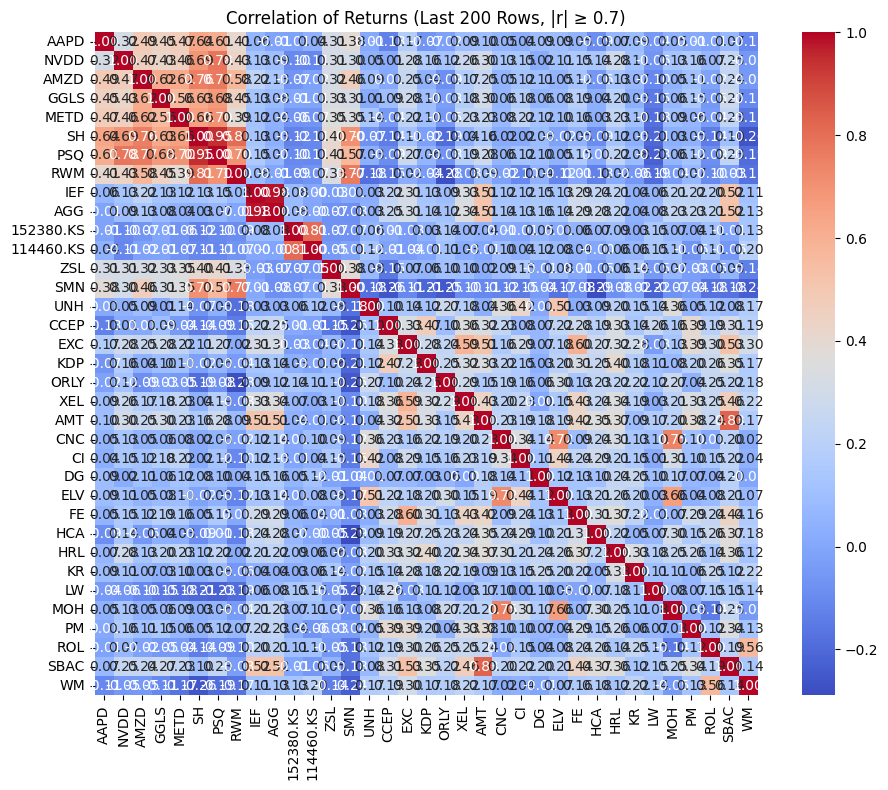


✅ Pairs with |correlation| ≥ 0.7 (Last 200 rows):
  - NVDD & PSQ: correlation = 0.78
  - AMZD & SH: correlation = 0.76
  - AMZD & PSQ: correlation = 0.77
  - SH & PSQ: correlation = 0.95
  - SH & RWM: correlation = 0.81
  - SH & SMN: correlation = 0.70
  - PSQ & RWM: correlation = 0.70
  - RWM & SMN: correlation = 0.77
  - IEF & AGG: correlation = 0.98
  - 152380.KS & 114460.KS: correlation = 0.81
  - AMT & SBAC: correlation = 0.83
  - CNC & ELV: correlation = 0.72
  - CNC & MOH: correlation = 0.75


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from datetime import datetime

# Parameters
N = 200  # Last N rows
C = 0.7  # Correlation threshold (absolute value)

# Paths
symbols_path = "/content/drive/MyDrive/Data/FNC/TT_Long_List.csv"
data_folder = "/content/drive/MyDrive/Data/FNC/Historical_Data"

# Load symbols
symbols_df = pd.read_csv(symbols_path)
symbols = symbols_df['[Symbol]'].dropna().unique().tolist()

# Initialize
price_data = pd.DataFrame()
excluded_symbols = []

# Load and merge adjusted close prices
for symbol in symbols:
    file_path = os.path.join(data_folder, f"{symbol}.csv")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        excluded_symbols.append(symbol)
        continue

    df = pd.read_csv(file_path)
    if 'Date' not in df.columns or 'Adj Close' not in df.columns:
        excluded_symbols.append(symbol)
        continue

    if len(df) < N:
        excluded_symbols.append(symbol)
        continue

    df = df.tail(N).reset_index(drop=True)
    df = df[['Adj Close']].rename(columns={'Adj Close': symbol})

    if price_data.empty:
        price_data = df
    else:
        price_data = pd.concat([price_data, df], axis=1)

# Drop rows with any missing values
price_data = price_data.dropna()

# Calculate returns
returns = price_data.pct_change().dropna()

# Correlation matrix
correlation_matrix = returns.corr()

# Print matrix
print(f"📊 Correlation matrix (last {N} rows):")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f"Correlation of Returns (Last {N} Rows, |r| ≥ {C})")
plt.tight_layout()
plt.show()

# Find strong correlation pairs
strong_pairs = []
valid_symbols = correlation_matrix.columns.tolist()

for sym1, sym2 in combinations(valid_symbols, 2):
    corr = correlation_matrix.loc[sym1, sym2]
    if abs(corr) >= C:
        strong_pairs.append((sym1, sym2, corr))

# Display pairs
if strong_pairs:
    print(f"\n✅ Pairs with |correlation| ≥ {C} (Last {N} rows):")
    for s1, s2, r in strong_pairs:
        print(f"  - {s1} & {s2}: correlation = {r:.2f}")
else:
    print(f"\n✅ No pairs found with |correlation| ≥ {C} in the last {N} rows.")

# Display excluded symbols
if excluded_symbols:
    print("\n⚠️ Excluded symbols due to insufficient data (< {} rows):".format(N))
    for sym in excluded_symbols:
        print(f"  - {sym}")

# Save results
now_str = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"/content/drive/MyDrive/Data/FNC/TT_Corr_Result_{now_str}.csv"

# 1. Save correlation matrix
correlation_matrix.to_csv(output_path, index=True)

# 2. Append strong pairs
with open(output_path, 'a') as f:
    f.write(f"\n\nPairs with |correlation| ≥ {C:.2f} (Last {N} rows)\n")
    f.write("Symbol 1,Symbol 2,Correlation\n")
    if strong_pairs:
        for s1, s2, r in strong_pairs:
            f.write(f"{s1},{s2},{r:.4f}\n")
    else:
        f.write("None\n")

# 3. Append excluded symbols
with open(output_path, 'a') as f:
    f.write(f"\n\nExcluded symbols (data length < {N} rows):\n")
    if excluded_symbols:
        for sym in excluded_symbols:
            f.write(f"{sym}\n")
    else:
        f.write("None\n")
